# Super.FELT using Reported Optimum Hyperparameters

The following code is an interpretation of the Super.FELT algorithm as presented in the paper
[Super.FELT: supervised feature extraction learning using triplet loss for drug response prediction with multi-omics data][1] 
by Park, S., Soh, J. & Lee, H. (2021) using the superfelt package provided in this repository, 
hyperparameter optimization using [Optuna][2], and the [PyTorch Lightning][3]
framework. 

[1]: https://doi.org/10.1186/s12859-021-04146-z
[2]: https://optuna.org/
[3]: https://lightning.ai/docs/pytorch/latest/

In [1]:
import moli
import superfelt

import uuid
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy
device = torch.device('cuda')
torch.set_float32_matmul_precision('medium')

import pytorch_lightning as pl
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

from sklearn.model_selection import RepeatedStratifiedKFold
from torchmetrics import AUROC
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,4)})

In [2]:
num_workers=32
pin_memory=False
persistent_workers=True

## Drug Response Data

The drug response data was downloaded from the [Super.FELT Zenodo repository Version 2][3].
The GDSC response data was not provided in the repository and generated from the original
sources provided in the [MOLI GitHub repository annotations notebook][4]. The reported
optimal hyperparameter set (reported hp) and reported testing set AUC (reported auc) is
taken from [Table S27 of the original paper][5].


[3]: https://doi.org/10.5281/zenodo.4895679
[4]: https://github.com/hosseinshn/MOLI/blob/master/preprocessing_scr/annotations.ipynb
[5]: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04146-z#additional-information

In [3]:
zenodo_dir = './data/4895679'

In [4]:
study_sets = pd.DataFrame([
    ['PDX', '5-Fluorouracil', 'GDSC', 0, 0.865],
    ['PDX', 'Cetuximab', 'GDSC', 3, 0.636],
    ['PDX', 'Erlotinib', 'GDSC', 4, 0.742],
    ['PDX', 'Gemcitabine', 'GDSC', 0, 0.682],
    ['PDX', 'Paclitaxel', 'GDSC', 7, 0.72],
    ['PDX', 'Trametinib', 'GDSC', 3, 0.555],
    ['TCGA', '5-Fluorouracil', 'GDSC', 1, 0.493],
    ['TCGA', 'Cetuximab', 'GDSC', 7, 0.353],
    ['TCGA', 'Cisplatin', 'GDSC', 0, 0.759],
    ['TCGA', 'Docetaxel', 'GDSC', 4, 0.611],
    ['TCGA', 'Doxorubicin', 'GDSC', 0, 0.51],
    ['TCGA', 'Erlotinib', 'GDSC', 3, 0.85],
    ['TCGA', 'Etoposide', 'GDSC', 5, 0.02],
    ['TCGA', 'Gemcitabine', 'GDSC', 4, 0.634],
    ['TCGA', 'Mitomycin C', 'GDSC', 0, 0.64],
    ['TCGA', 'Paclitaxel', 'GDSC', 4, 0.529],
    ['TCGA', 'Sorafenib', 'GDSC', 0, 0.818],
    ['TCGA', 'Tamoxifen', 'GDSC', 5, 0.758],
    ['TCGA', 'Temozolomide', 'GDSC', 0, 0.634]
], columns = ['testing set', 'drug', 'training set', 'reported hp', 'reported AUROC'])
study_sets

,testing set,drug,training set,reported hp,reported AUROC
0,PDX,5-Fluorouracil,GDSC,0,0.865
1,PDX,Cetuximab,GDSC,3,0.636
2,PDX,Erlotinib,GDSC,4,0.742
3,PDX,Gemcitabine,GDSC,0,0.682
4,PDX,Paclitaxel,GDSC,7,0.720
5,PDX,Trametinib,GDSC,3,0.555
6,TCGA,5-Fluorouracil,GDSC,1,0.493
7,TCGA,Cetuximab,GDSC,7,0.353
8,TCGA,Cisplatin,GDSC,0,0.759
9,TCGA,Docetaxel,GDSC,4,0.611


## PyTorch Lightning

Model wrapper class definitions to use PyTorch Lightning framework

In [5]:
class LitSuperFeltNet(pl.LightningModule):
    
    def __init__(self, model, optimizer, margin):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.margin = margin
        self.train_auroc = AUROC(task='binary', compute_on_step=False)
        self.val_auroc = AUROC(task='binary', compute_on_step=False)
    
    def forward(self, x_e, x_m, x_c):
        return self.model(x_e, x_m, x_c)
    
    @staticmethod
    def invalid_batch(target):
        return torch.mean(target) == 0. or torch.mean(target) == 1. or len(target)<=2
            
    @staticmethod
    def invalid_pred(pred):
        return torch.any(torch.isnan(pred)).item()
    
    def criterion(self, enc_e, enc_m, enc_c, y_hat, y):
        loss_e = moli.loss.moli_triplet_score(y, enc_e, self.margin)
        loss_m = moli.loss.moli_triplet_score(y, enc_m, self.margin)
        loss_c = moli.loss.moli_triplet_score(y, enc_c, self.margin)
        loss_cl = binary_cross_entropy(y_hat, y.view(-1,1))
        loss = loss_e + loss_m + loss_c + loss_cl
        return loss
    
    def training_step(self, batch, batch_idx):
        x_e, x_m, x_c, y = batch
        if self.invalid_batch(y):
            return None
        enc_e, enc_m, enc_c, y_hat = self.model(x_e, x_m, x_c)
        if self.invalid_pred(y_hat):
            return None
        loss = self.criterion(enc_e, enc_m, enc_c, y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=False)
        # AUROC
        self.train_auroc.update(y_hat, y)
        try:
            self.log('train_auroc', self.train_auroc, on_step=False, on_epoch=True, prog_bar=True)
        except ValueError:
            pass
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_e, x_m, x_c, y = batch
        if self.invalid_batch(y):
            return None
        enc_e, enc_m, enc_c, y_hat = self.model(x_e, x_m, x_c)
        if self.invalid_pred(y_hat):
            return None
        loss = self.criterion(enc_e, enc_m, enc_c, y_hat, y)
        self.log("valid_loss", loss, on_step=True, on_epoch=True, prog_bar=False)
        # AUROC
        self.val_auroc.update(y_hat, y)
        try:
            self.log('val_auroc', self.val_auroc, on_step=False, on_epoch=True, prog_bar=True)
        except ValueError:
            pass
        
    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = self.optimizer
        return optimizer

## Bayesian Hyperparameter Optimization

Determine the optimal set of hyperparameters. The search-space was exprapolated from the
values available in the hyper-parameter sets in Table S7 of the Super.Felt paper.

### Hyperparameter selection utility functions

Utility functions for selecting hyperparameters during optimization and generating 
the final model. `define_*` functions select a new set of hyperparamters visa Optuna's
suggest methods and `get_*` functions return objects based on a provided set of hyperparameters.

In [6]:
def define_model(trial, exp_size, mut_size, cna_size):
    # Number of nodes
    exp_hl = trial.suggest_int("exp_hl", 16, 512, step=16)
    mut_hl = trial.suggest_int("mut_hl", 16, 512, step=16)
    cna_hl = trial.suggest_int("cna_hl", 16, 512, step=16)
    # Dropout rate
    enc_dr = trial.suggest_float("enc_dr", 0., 0.6, step=0.1)
    cls_dr = trial.suggest_float("cls_dr", 0., 0.6, step=0.1)
    # Sub-network epochs
    exp_ep = trial.suggest_int("exp_ep", 2, 10, step=1)
    mut_ep = trial.suggest_int("mut_ep", 2, 10, step=1)
    cna_ep = trial.suggest_int("cna_ep", 2, 10, step=1)
    cls_ep = trial.suggest_int("cls_ep", 2, 10, step=1)
    epochs = exp_ep + mut_ep + cna_ep + cls_ep
    trial.set_user_attr('epochs', epochs)
    
    return get_model(exp_size, exp_hl, exp_ep, mut_size, mut_hl, mut_ep,
                     cna_size, cna_hl, cna_ep, enc_dr, cls_dr)

def get_model(exp_size, exp_hl, exp_ep, mut_size, mut_hl, mut_ep,
              cna_size, cna_hl, cna_ep, enc_dr, cls_dr):
    model = superfelt.nn.SuperFeltNet(exp_size, exp_hl, exp_ep,
                                      mut_size, mut_hl, mut_ep,
                                      cna_size, cna_hl, cna_ep,
                                      enc_dr, cls_dr)
    return model

def define_optimizer(trial, model):
    # Learning rate
    enc_lr = trial.suggest_float("enc_lr", 1e-3, 1e-1, log=True)
    cls_lr = trial.suggest_float("cls_lr", 1e-3, 1e-1, log=True)
    # Weight decay 
    enc_wd = trial.suggest_float("enc_wd", 1e-3, 1e-1, log=True)
    cls_wd = trial.suggest_float("cls_wd", 1e-3, 1e-1, log=True)
    
    return get_optimizer(model, enc_lr, enc_wd, cls_lr, cls_wd)

def get_optimizer(model, enc_lr, enc_wd, cls_lr, cls_wd):
    optimizer = superfelt.optim.SuperFeltAdagrad(
        model, enc_lr, enc_wd, cls_lr, cls_wd)
    return optimizer


### Optuna Objective Function

Runs a 5-Fold cross validation with 2 repeats of a PyTorch Lightning trainer. The reported metric for optimimzation 
is the AUROC of the validation set.

In [7]:
def objective_ds(trial, ds):
    
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=74656)
    stdscaler = StandardScaler()
    
    logs = {
        'train_auroc': [],
        'val_auroc': [],
        'stopped_epoch': [],
        'logger_version': []
    }
    
    for fidx, (train_idx, valid_idx) in enumerate(skf.split(ds['train']['expression'], ds['train']['response'])):
        # Training set
        train_exp = stdscaler.fit_transform(ds['train']['expression'][train_idx, :])
        train_exp = torch.FloatTensor(train_exp)
        train_mut = torch.FloatTensor(ds['train']['mutation'][train_idx, :])
        train_cna = torch.FloatTensor(ds['train']['cna'][train_idx, :])
        train_y = torch.FloatTensor(ds['train']['response'][train_idx])
        # Validation set
        valid_exp = stdscaler.transform(ds['train']['expression'][valid_idx, :])
        valid_exp = torch.FloatTensor(valid_exp)
        valid_mut = torch.FloatTensor(ds['train']['mutation'][valid_idx, :])
        valid_cna = torch.FloatTensor(ds['train']['cna'][valid_idx, :])
        valid_y = torch.FloatTensor(ds['train']['response'][valid_idx])
        # Generate dataloaders
        batch_size = trial.suggest_int("batch_size", 8, 64, step=8)
        train_dataset = torch.utils.data.TensorDataset(train_exp, train_mut, train_cna, train_y)
        train_loader = moli.utils.moli_dataloader(train_dataset, batch_size=batch_size,
                                                  num_workers=num_workers, pin_memory=pin_memory, 
                                                  persistent_workers=persistent_workers)
        valid_dataset = torch.utils.data.TensorDataset(valid_exp, valid_mut, valid_cna, valid_y)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, 
                                                   num_workers=num_workers, pin_memory=pin_memory, 
                                                   persistent_workers=persistent_workers)
        # Model
        margin = trial.suggest_float("margin", 0.5, 3.5, step=0.5)
        model = define_model(trial, train_exp.shape[1], train_mut.shape[1], train_cna.shape[1])
        optimizer = define_optimizer(trial, model)
        litmodel = LitSuperFeltNet(model, optimizer, margin)
        # Training
        epochs = trial.user_attrs['epochs']
        trainer = pl.Trainer(
            max_epochs=epochs,
            accelerator="gpu",
            devices=1,
            log_every_n_steps=1,
            val_check_interval=1.0,
            limit_val_batches=1.0,
            check_val_every_n_epoch=1,
            num_sanity_val_steps=0,
            enable_checkpointing=False,
            enable_progress_bar=False,
        )
        trainer.fit(model=litmodel, train_dataloaders=train_loader, val_dataloaders=valid_loader)
        logs['train_auroc'].append(trainer.callback_metrics["train_auroc"].item())
        logs['val_auroc'].append(trainer.callback_metrics["val_auroc"].item())
        logs['stopped_epoch'].append(trainer.current_epoch)
        logs['logger_version'].append(trainer.logger.version)
    trial.set_user_attr("train_auroc", logs['train_auroc'])
    trial.set_user_attr("val_auroc", logs['val_auroc'])
    trial.set_user_attr("stopped_epoch", logs['stopped_epoch'])
    trial.set_user_attr("logger_version", logs['logger_version'])
    return np.mean(logs['val_auroc'])
        
        

### Run Optuna

Run 50 optimization trials for each dataset.

In [8]:
%%capture output

n_trials = 50
run_uuid = str(uuid.uuid4())
storage_name = "sqlite:///saved_studies/superfelt_optuna.db"

for study_set in study_sets.to_dict('records'):
    ds = superfelt.utils.get_dataset(study_set['drug'], study_set['training set'], study_set['testing set'], zenodo_dir)
    study_name = f"{study_set['drug']}:{study_set['training set']}:{study_set['testing set']}:{run_uuid}"
    study = optuna.create_study(
        direction="maximize",
        study_name = study_name,
        storage = storage_name)
    func = lambda trial: objective_ds(trial, ds)
    study.optimize(func, n_trials=n_trials)


[I 2023-04-14 04:40:14,138] A new study created in RDB with name: 5-Fluorouracil:GDSC:PDX:bee34b90-165a-4475-8eca-cbc1972594dc
[I 2023-04-14 04:42:32,936] Trial 0 finished with value: 0.7267682611942291 and parameters: {'batch_size': 40, 'margin': 0.5, 'exp_hl': 240, 'mut_hl': 176, 'cna_hl': 432, 'enc_dr': 0.30000000000000004, 'cls_dr': 0.6, 'exp_ep': 9, 'mut_ep': 4, 'cna_ep': 8, 'cls_ep': 6, 'enc_lr': 0.09778389895240877, 'cls_lr': 0.0015565148846162255, 'enc_wd': 0.023306935164753753, 'cls_wd': 0.012579684027498693}. Best is trial 0 with value: 0.7267682611942291.
[I 2023-04-14 04:44:52,965] Trial 1 finished with value: 0.8004714190959931 and parameters: {'batch_size': 32, 'margin': 3.5, 'exp_hl': 336, 'mut_hl': 128, 'cna_hl': 368, 'enc_dr': 0.6, 'cls_dr': 0.30000000000000004, 'exp_ep': 3, 'mut_ep': 3, 'cna_ep': 6, 'cls_ep': 8, 'enc_lr': 0.0014241670449216478, 'cls_lr': 0.07965175815948841, 'enc_wd': 0.009857943454311105, 'cls_wd': 0.06198790937925261}. Best is trial 1 with value: 0.

### Visualize Results
Plot results of Optuna optimization. Green dots represent the AUROC of the cross-validation folds, red dots
are the average AUROC for that trial, and the grey bar is the standard deviation of the average AUROC
across 5 subsequent trials.

In [9]:
def plot_trials(study):
    tr_df = study.trials_dataframe().rename(columns={'number': 'Trial', 'user_attrs_val_auroc': 'Val. AUROC'})[['Trial', 'Val. AUROC']].explode('Val. AUROC')
    tr_avg_df = tr_df.groupby('Trial').mean().sort_values('Trial').reset_index()
    sns.set(rc={'figure.figsize':(12, 2)})
    col = sns.color_palette('hls', 5)
    sns.scatterplot(tr_df, x='Trial', y='Val. AUROC', marker='.', color = col[1])
    sns.scatterplot(tr_avg_df, x='Trial', y='Val. AUROC', color = col[0])
    tr_df_bin = tr_avg_df.assign(trial_bin = tr_avg_df.index//5 * 5 + 2.5)
    sns.lineplot(data=tr_df_bin, x="trial_bin", y="Val. AUROC", marker='', linestyle='', errorbar=('sd'))

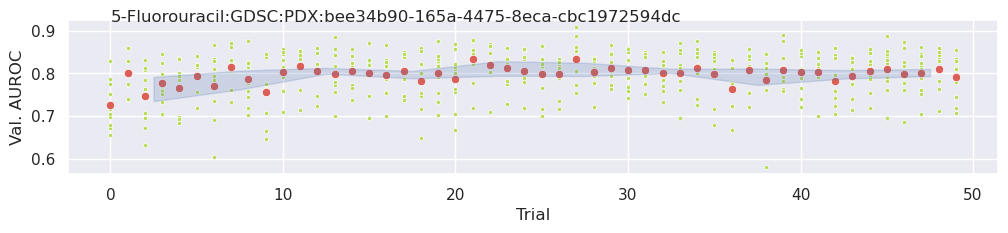

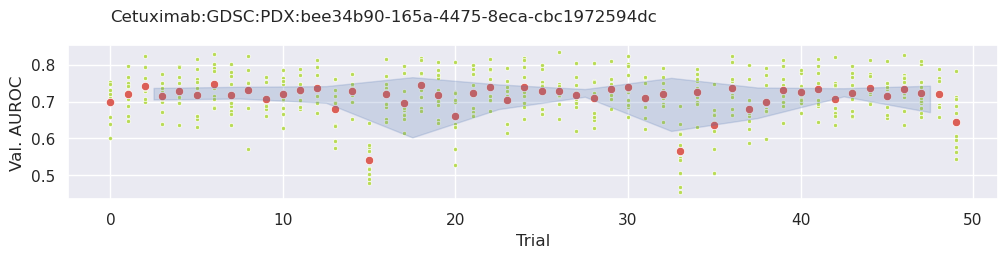

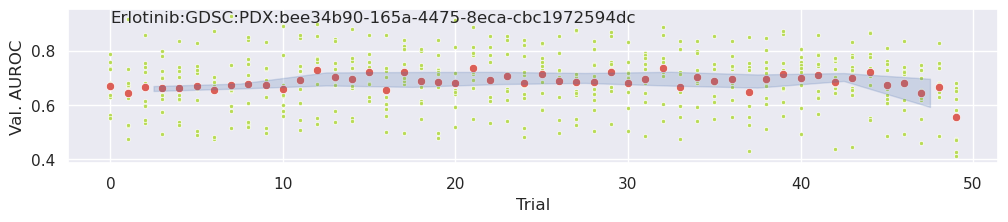

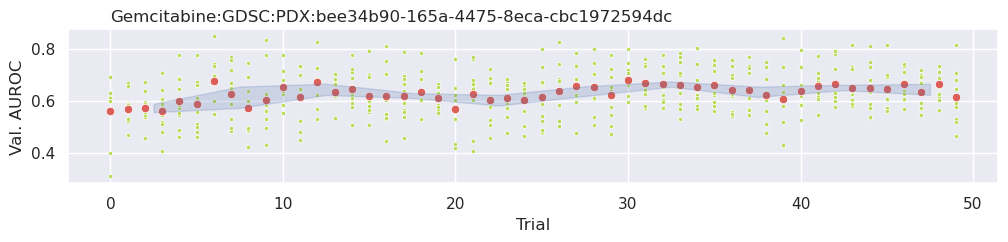

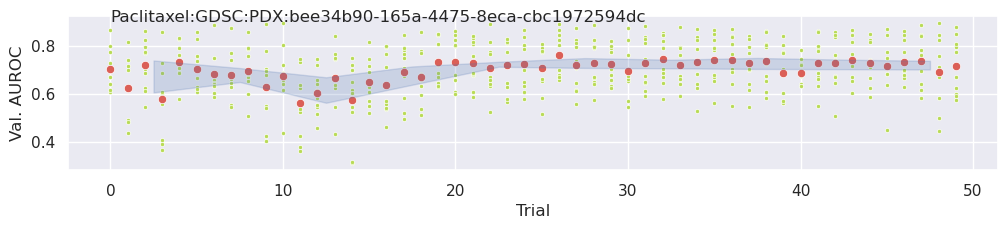

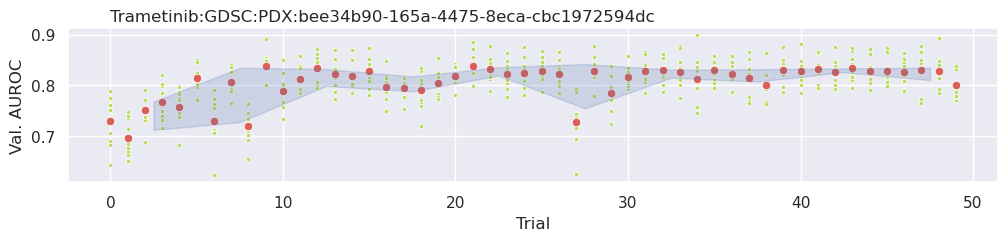

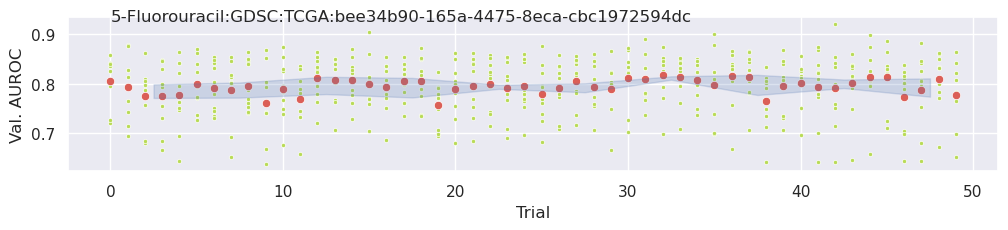

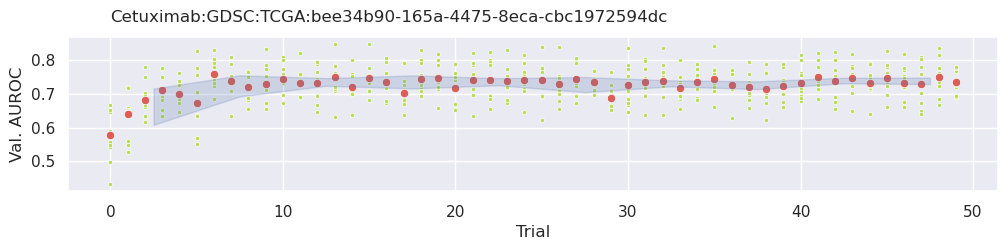

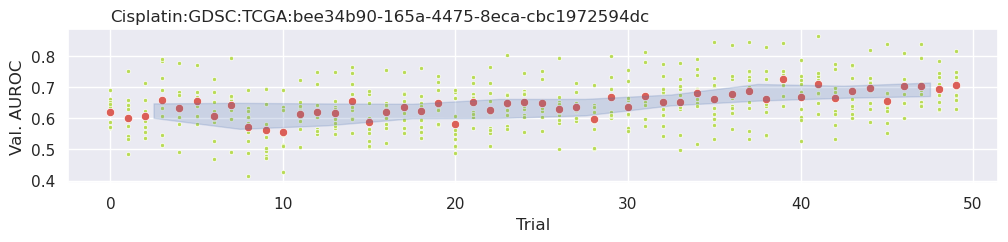

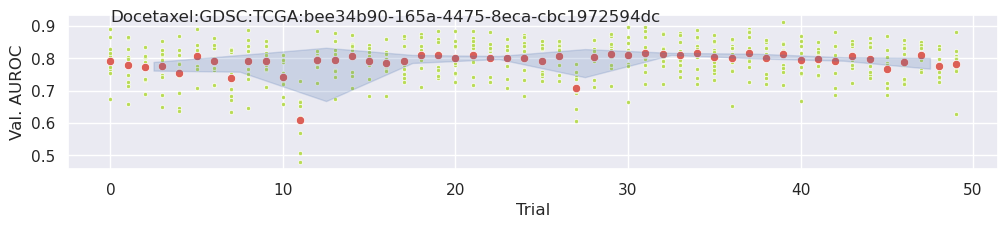

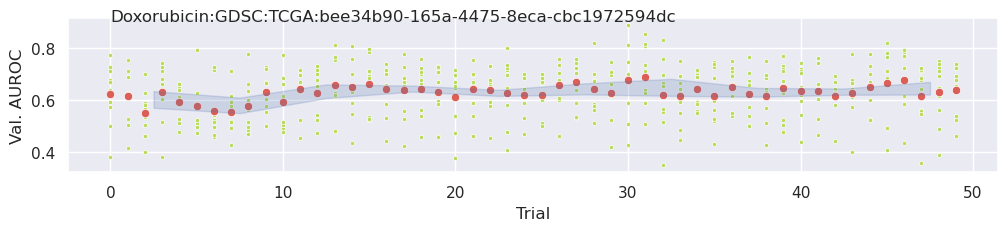

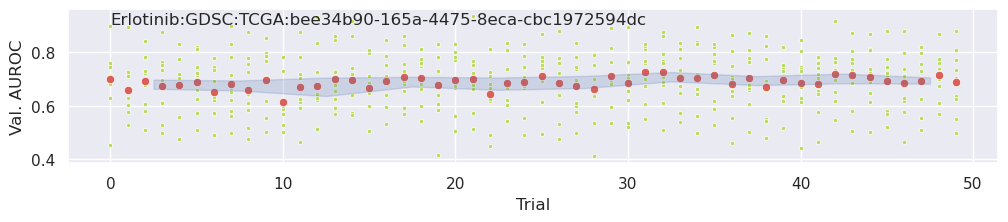

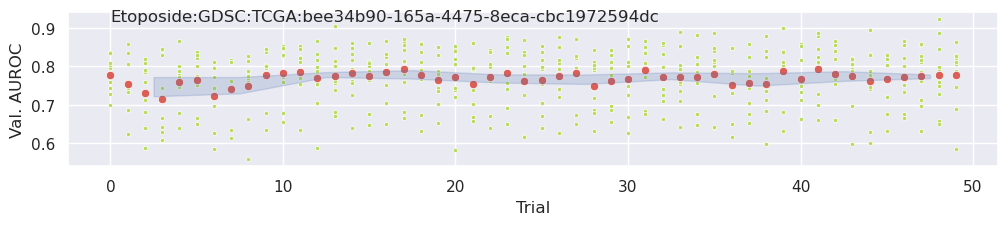

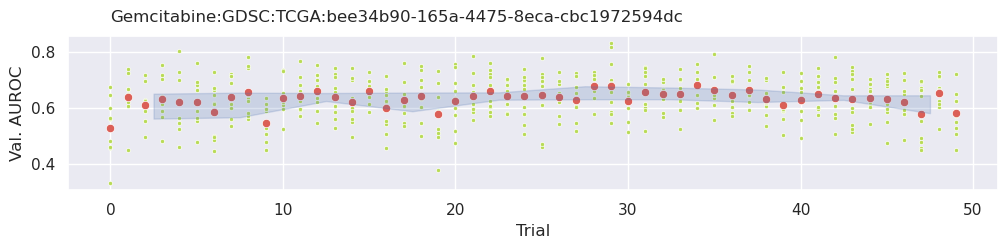

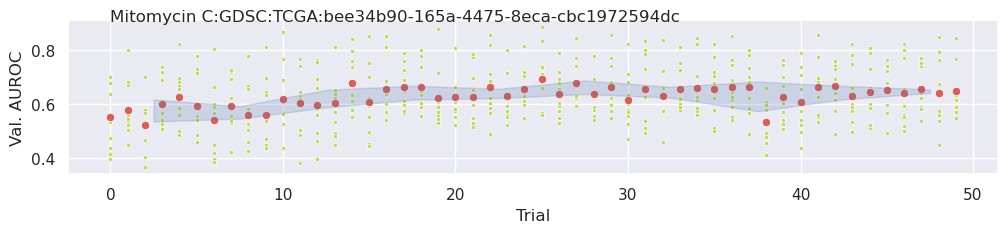

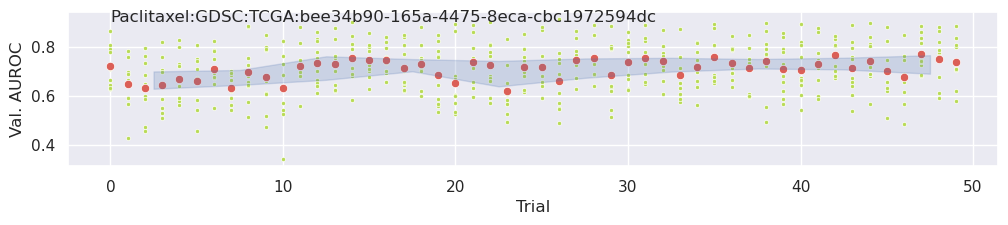

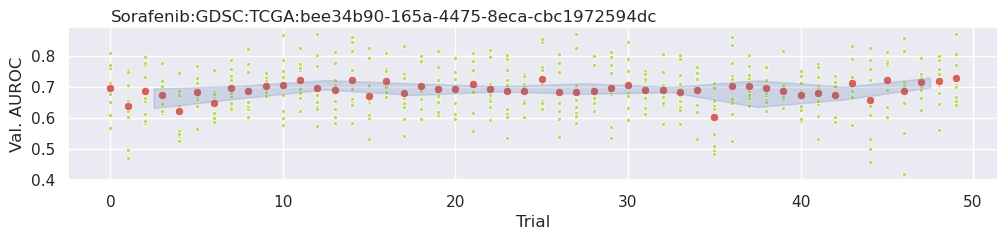

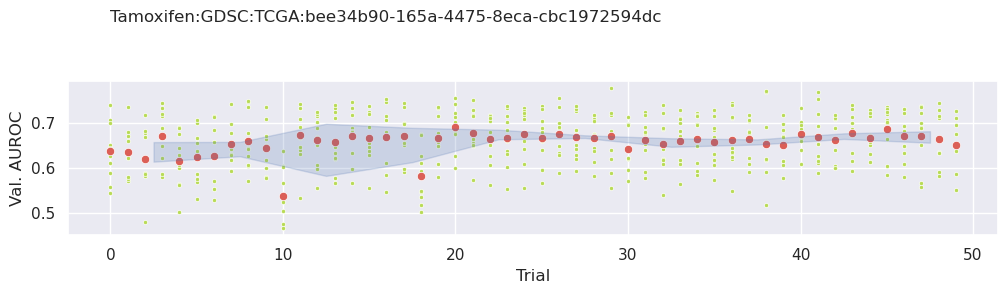

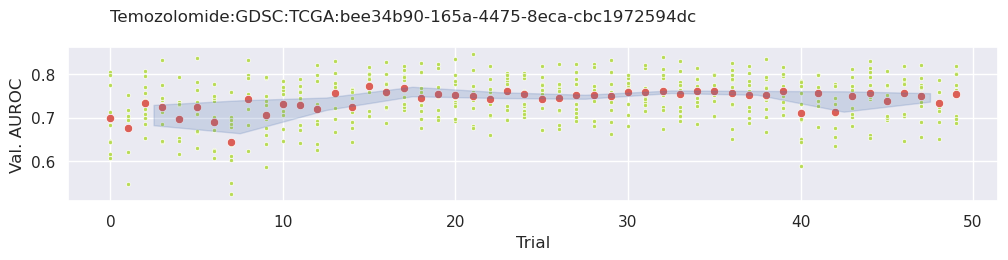

In [10]:
studies = [i.study_name for i in optuna.study.get_all_study_summaries(storage_name) if run_uuid in i.study_name]
for study_name in studies:
    study = optuna.load_study(study_name=study_name, storage=storage_name)
    plot_trials(study)
    plt.text(0, 0.95, study.study_name, horizontalalignment='left', verticalalignment='top')
    plt.show()

## Final Model and Test Set

In [11]:
%%capture output

results = []
replicates = 50
stdscaler = StandardScaler()

for study_set in study_sets.to_dict('records'):
    ds = superfelt.utils.get_dataset(study_set['drug'], study_set['training set'], study_set['testing set'], zenodo_dir)
    study_name = f"{study_set['drug']}:{study_set['training set']}:{study_set['testing set']}:{run_uuid}"
    study = optuna.load_study(study_name=study_name, storage=storage_name)
    hp = study.best_trial.params
    hp['epochs'] = study.best_trial.user_attrs['epochs']
    # Training set
    train_exp = stdscaler.fit_transform(ds['train']['expression'])
    train_exp = torch.FloatTensor(train_exp)
    train_mut = torch.FloatTensor(ds['train']['mutation'])
    train_cna = torch.FloatTensor(ds['train']['cna'])
    train_y = torch.FloatTensor(ds['train']['response'])
    # Test set
    test_exp = stdscaler.transform(ds['test']['expression'])
    test_exp = torch.FloatTensor(test_exp)
    test_mut = torch.FloatTensor(ds['test']['mutation'])
    test_cna = torch.FloatTensor(ds['test']['cna'])
    test_y = torch.FloatTensor(ds['test']['response'])
    # Generate dataloaders
    batch_size = hp["batch_size"]
    train_dataset = torch.utils.data.TensorDataset(train_exp, train_mut, train_cna, train_y)
    train_loader = moli.utils.moli_dataloader(train_dataset, batch_size=batch_size,
                                              num_workers=num_workers, pin_memory=pin_memory, 
                                              persistent_workers=persistent_workers)
    test_dataset = torch.utils.data.TensorDataset(test_exp, test_mut, test_cna, test_y)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                                              num_workers=num_workers, pin_memory=pin_memory, 
                                              persistent_workers=persistent_workers)
    for ridx in range(replicates):
        # Model
        model = get_model(train_exp.shape[1], hp['exp_hl'], hp['exp_ep'], 
                          train_mut.shape[1], hp['mut_hl'], hp['mut_ep'],
                          train_cna.shape[1], hp['cna_hl'], hp['cna_ep'], 
                          hp['enc_dr'], hp['cls_dr'])
        optimizer = get_optimizer(model, hp['enc_lr'], hp['enc_wd'], hp['cls_lr'], hp['cls_wd'])
        litmodel = LitSuperFeltNet(model, optimizer, hp['margin'])
        trainer = pl.Trainer(
            max_epochs=hp['epochs'],
            accelerator="gpu",
            devices=1,
            log_every_n_steps=1,
            enable_checkpointing=False,
            enable_progress_bar=False
        )
        trainer.fit(model=litmodel, train_dataloaders=train_loader)
        # Evaluation
        results.append({
            'drug': study_set['drug'], 
            'training set': study_set['training set'], 
            'testing set': study_set['testing set'],
            'ridx': ridx,
            'train_auroc': trainer.callback_metrics["train_auroc"].item(),
            'train_loss': trainer.callback_metrics["train_loss"].item()
        })
        trainer.test(model=litmodel, dataloaders=test_loader)
        results[-1].update({
            'val_auroc': trainer.callback_metrics["val_auroc"].item(),
            'val_loss': trainer.callback_metrics["val_auroc"].item()
        })
                                            

## Results

The following is a plot of the observed test AUCs resulting from networks Optuna determined hyperparameters.
The reported AUROC from the MOLI paper is displayed as a red X.

In [12]:
test_df = pd.DataFrame(results).rename(columns={'val_auroc': 'AUROC'})

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 74.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 76.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 48.0% of the points cannot be plac

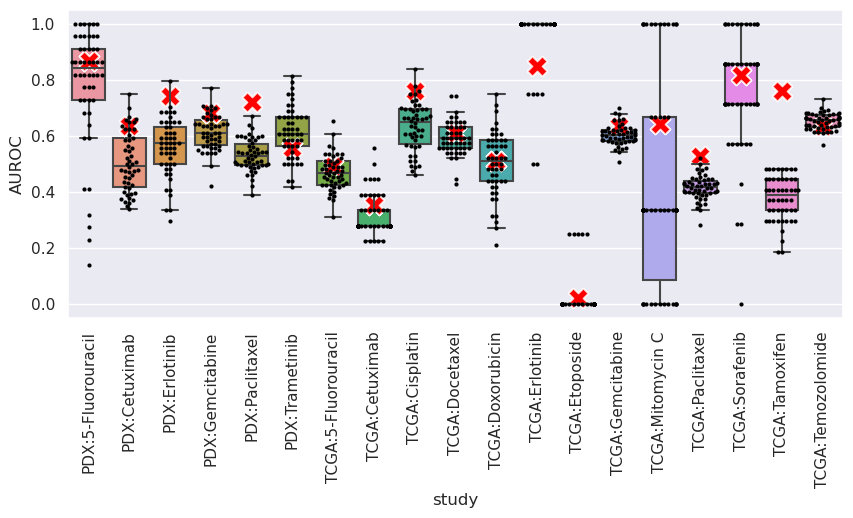

In [17]:
sns.set(rc={'figure.figsize':(10,4)})
plot_df = test_df.merge(study_sets)
plot_df['study'] = plot_df['testing set'] + ':' + plot_df['drug']
ax = sns.boxplot(y='AUROC', x='study', data=plot_df, showfliers = False)
ax.tick_params(axis='x', labelrotation=90)
ax = sns.scatterplot(y='reported AUROC', x='study', data=plot_df, color='red', alpha=0.7, marker='X', s=200, axes=ax)
ax = sns.swarmplot(y='AUROC', x='study', data=plot_df, color='black', s=3, axes=ax)

In [18]:
(test_df
 .groupby(['drug','training set','testing set'])
 .agg(**{"min AUROC": ('AUROC', 'min'), 'mean AUROC': ('AUROC', 'mean'), 'median AUROC': ('AUROC', 'median'), 'max AUROC': ('AUROC', 'max')})
 .reset_index()
 .merge(study_sets)
 .sort_values(['testing set', 'drug'])
 .style.highlight_max(subset = ['mean AUROC', 'reported AUROC'],color = 'lightgreen', axis = 1)
 .format(precision=2)
)

,drug,training set,testing set,min AUROC,mean AUROC,median AUROC,max AUROC,reported hp,reported AUROC
0,5-Fluorouracil,GDSC,PDX,0.14,0.78,0.84,1.00,0,0.86
2,Cetuximab,GDSC,PDX,0.34,0.51,0.49,0.75,3,0.64
7,Erlotinib,GDSC,PDX,0.30,0.56,0.57,0.80,4,0.74
10,Gemcitabine,GDSC,PDX,0.42,0.61,0.61,0.77,0,0.68
13,Paclitaxel,GDSC,PDX,0.39,0.53,0.53,0.67,7,0.72
18,Trametinib,GDSC,PDX,0.42,0.61,0.60,0.81,3,0.56
1,5-Fluorouracil,GDSC,TCGA,0.31,0.47,0.47,0.65,1,0.49
3,Cetuximab,GDSC,TCGA,0.22,0.32,0.28,0.56,7,0.35
4,Cisplatin,GDSC,TCGA,0.46,0.63,0.65,0.84,0,0.76
5,Docetaxel,GDSC,TCGA,0.43,0.59,0.59,0.74,4,0.61
